In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from filterpy.kalman import KalmanFilter

In [3]:
# Load the logged data
df = pd.read_csv("D:/3500/Project 3/breathing_log_dual_demo.csv")
time = df["Time(s)"].to_numpy()
voltage_cond = df["Conductive_Voltage(V)"].to_numpy()
voltage_pres = df["Pressure_Voltage(V)"].to_numpy()

In [4]:
# Apply moving average filter (window size = 5)
window_size = 5
ma_voltage_pres = pd.Series(voltage_pres).rolling(window=window_size, center=True).mean().bfill().ffill()
ma_voltage_cond = pd.Series(voltage_cond).rolling(window=window_size, center=True).mean().bfill().ffill()

In [5]:
def apply_Kalman_Filter (voltage_sensor):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])      # Initial state (voltage, velocity)
    kf.F = np.array([[1, 1], [0, 1]])   # State transition
    kf.H = np.array([[1, 0]])           # Measurement function
    kf.P *= 1000.                        # Covariance
    kf.R = 0.01                          # Measurement noise
    kf.Q = 1e-4 * np.eye(2)              # Process noise

    ka_voltage_sensor = []
    for z in voltage_sensor:
        kf.predict()
        kf.update(z)
        ka_voltage_sensor.append(kf.x[0])
    return ka_voltage_sensor

ka_voltage_cond = apply_Kalman_Filter(ma_voltage_cond)
ka_voltage_pres = apply_Kalman_Filter(ma_voltage_pres)

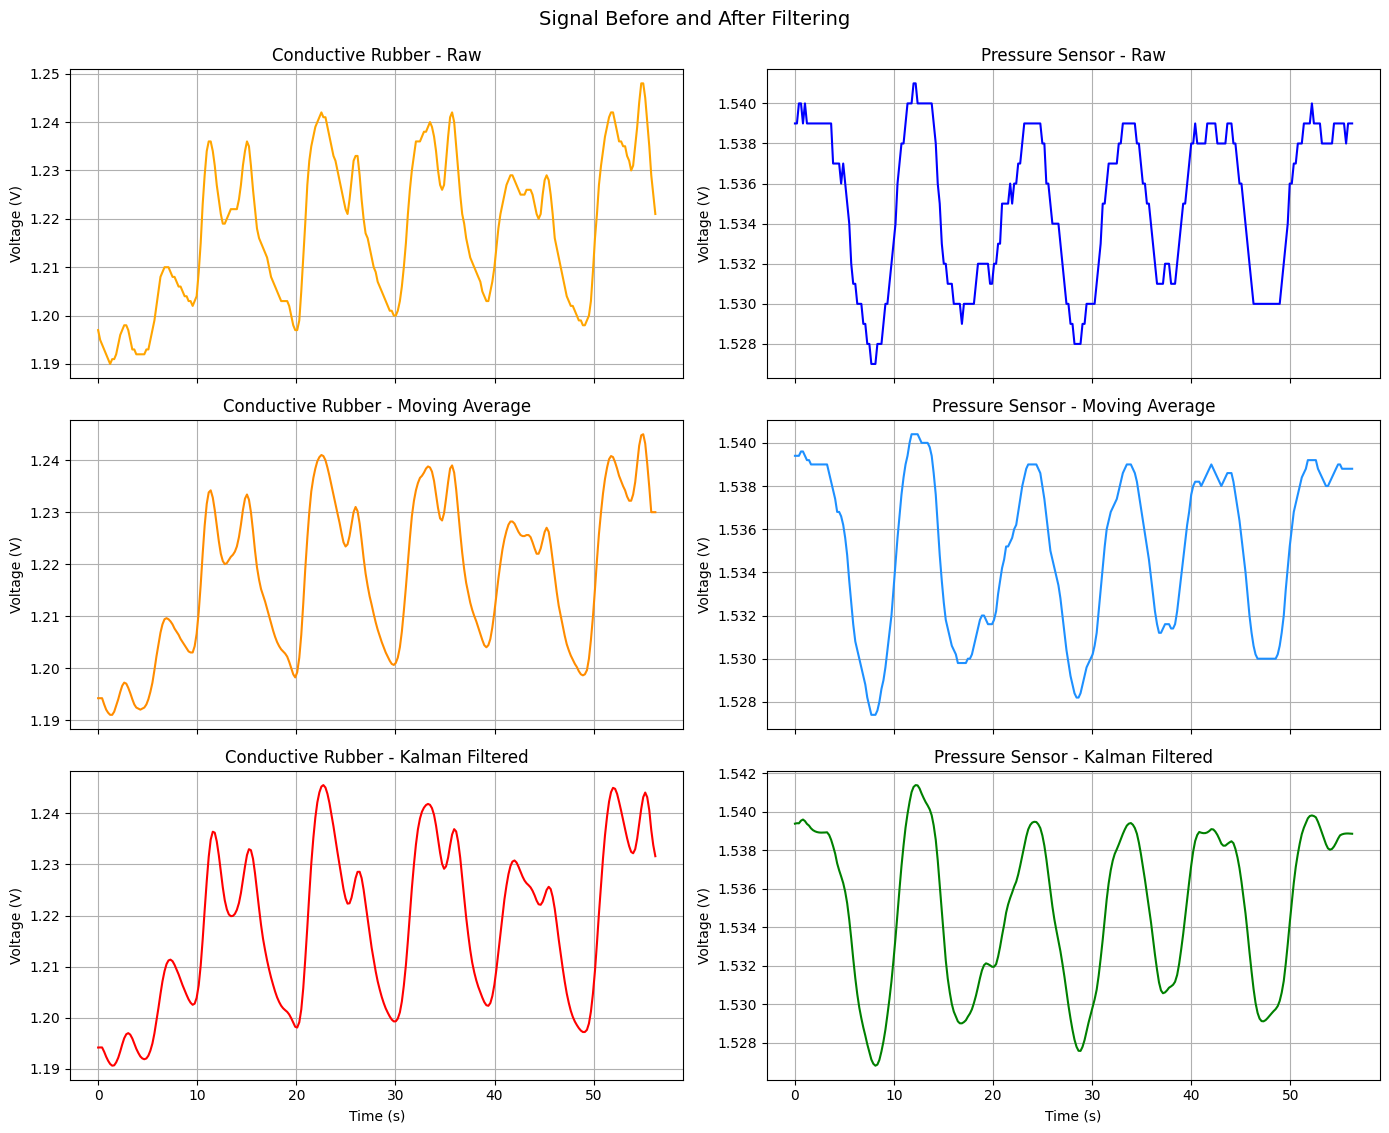

In [6]:
# Create subplots for before/after filtering
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
fig.suptitle("Signal Before and After Filtering", fontsize=14, y=0.94)

# Row 1: Raw
axs[0, 0].plot(time, voltage_cond, color='orange')
axs[0, 0].set_title("Conductive Rubber - Raw")
axs[0, 0].set_ylabel("Voltage (V)")
axs[0, 0].grid(True)

axs[0, 1].plot(time, voltage_pres, color='blue')
axs[0, 1].set_title("Pressure Sensor - Raw")
axs[0, 1].set_ylabel("Voltage (V)")
axs[0, 1].grid(True)

# Row 2: Moving Average
axs[1, 0].plot(time, ma_voltage_cond, color='darkorange')
axs[1, 0].set_title("Conductive Rubber - Moving Average")
axs[1, 0].set_ylabel("Voltage (V)")
axs[1, 0].grid(True)

axs[1, 1].plot(time, ma_voltage_pres, color='dodgerblue')
axs[1, 1].set_title("Pressure Sensor - Moving Average")
axs[1, 1].set_ylabel("Voltage (V)")
axs[1, 1].grid(True)

# Row 3: Kalman Filter
axs[2, 0].plot(time, ka_voltage_cond, color='red')
axs[2, 0].set_title("Conductive Rubber - Kalman Filtered")
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Voltage (V)")
axs[2, 0].grid(True)

axs[2, 1].plot(time, ka_voltage_pres, color='green')
axs[2, 1].set_title("Pressure Sensor - Kalman Filtered")
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("Voltage (V)")
axs[2, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

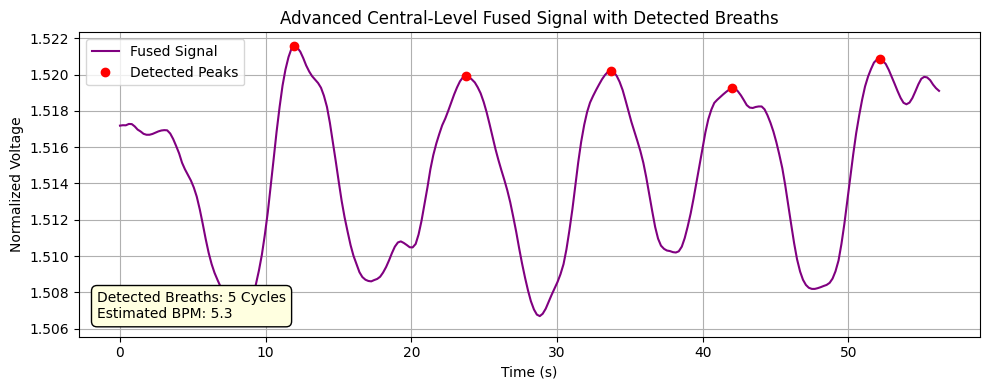

Detected breaths: 5
Estimated BPM: 5.3


: 

In [ ]:
ka_voltage_cond = np.array(ka_voltage_cond)
ka_voltage_pres = np.array(ka_voltage_pres)
# Weighted fusion based on inverse variance
var_cond = np.var(ka_voltage_cond)
var_pres = np.var(ka_voltage_pres)
w_cond = 1 / var_cond
w_pres = 1 / var_pres
fused_signal = (w_cond * ka_voltage_cond + w_pres * ka_voltage_pres) / (w_cond + w_pres)

# Peak detection
fs = 5  # 5 Hz sampling
min_distance = int(fs*5)  # At least 5s apart
peaks, _ = find_peaks(fused_signal, distance=min_distance, prominence=0.002)

# Estimate BPM
duration = time[-1] - time[0]
bpm = len(peaks) * 60 / duration

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time, fused_signal, label="Fused Signal", color='purple')
plt.plot(time[peaks], fused_signal[peaks], 'ro', label="Detected Peaks")
plt.title("Advanced Central-Level Fused Signal with Detected Breaths")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Voltage")
plt.grid(True)
plt.legend()
plt.tight_layout()

info_text = f"Detected Breaths: {len(peaks)} Cycles\nEstimated BPM: {bpm:.1f}"
plt.text(
    0.02, 0.15, info_text,
    transform=plt.gca().transAxes,  # relative to axes
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='black')
)

plt.show()

print(f"Detected breaths: {len(peaks)}")
print(f"Estimated BPM: {bpm:.1f}")